# Perbandingan Vision Transformer: Swin Transformer vs DeiT vs MAE
## Klasifikasi Dataset Bunga (Flowers Dataset)
### Rustian Afencius Marbun (122140155)

**Dataset:** [Flowers Dataset](https://www.kaggle.com/datasets/imsparsh/flowers-dataset)  
**Model yang Digunakan:**
1. **Swin Transformer** - Hierarchical Vision Transformer dengan Shifted Windows
2. **DeiT** - Data-efficient Image Transformer
3. **MAE** - Masked Autoencoder Vision Transformer

---
Notebook ini bertujuan untuk membandingkan kinerja ketiga model Vision Transformer tersebut dalam tugas klasifikasi citra bunga. Metrik yang dibandingkan meliputi akurasi, kecepatan inferensi, dan ukuran model.


## 1. Persiapan Lingkungan dan Instalasi Pustaka
Bagian ini melakukan instalasi library yang dibutuhkan dan mengimpor modul-modul penting.


In [ ]:
# Instalasi library yang diperlukan
# Gunakan requirements.txt jika tersedia untuk memastikan versi yang konsisten
import os
if os.path.exists('requirements.txt'):
    print("Menginstal dari requirements.txt...")
    !pip install -q -r requirements.txt
else:
    print("requirements.txt tidak ditemukan, menginstal paket secara manual...")
    !pip install -q timm torch torchvision kagglehub scikit-learn matplotlib seaborn pandas pillow tqdm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import library standar
import os
import zipfile
import shutil
import random
import time
from pathlib import Path
from collections import Counter

# Import library untuk pengolahan data dan visualisasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Import PyTorch dan komponen terkait
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm  # Library untuk model Vision Transformer (PyTorch Image Models)

# Import Scikit-learn untuk metrik evaluasi
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

# Konfigurasi peringatan dan tampilan plot
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Mengatur seed untuk reproduktifitas (agar hasil konsisten setiap kali dijalankan)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Deteksi perangkat (GPU atau CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan perangkat: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Versi CUDA: {torch.version.cuda}")


Using device: cuda
GPU: NVIDIA GeForce RTX 2050
CUDA Version: 12.1


## 2. Unduh dan Muat Dataset
Mengunduh dataset Flowers dari Kaggle jika belum tersedia secara lokal.


In [ ]:
import kagglehub
import shutil

LOCAL_DATA_PATH = './flowers-dataset'
KAGGLE_DATASET = 'imsparsh/flowers-dataset'

# Cek apakah dataset sudah ada
if os.path.exists(LOCAL_DATA_PATH):
    print(f"✓ Dataset ditemukan secara lokal di {LOCAL_DATA_PATH}")
else:
    print(f"✗ Dataset tidak ditemukan. Mengunduh dari Kaggle menggunakan kagglehub...")
    
    # Download latest version
    path = kagglehub.dataset_download(KAGGLE_DATASET)
    print(f"Dataset diunduh sementara ke: {path}")
    
    # Pindahkan atau salin ke LOCAL_DATA_PATH agar struktur folder sesuai dengan kode selanjutnya
    print(f"Menyalin dataset ke {LOCAL_DATA_PATH}...")
    shutil.copytree(path, LOCAL_DATA_PATH, dirs_exist_ok=True)
    
    print("✓ Unduhan dan penyalinan selesai!")

✓ Dataset found locally at ./flowers-dataset


In [ ]:
# Menentukan path direktori data
train_dir = Path(LOCAL_DATA_PATH) / 'train'
test_dir = Path(LOCAL_DATA_PATH) / 'test'
test_csv_path = Path(LOCAL_DATA_PATH) / 'Testing_set_flower.csv'
sample_submission_path = Path(LOCAL_DATA_PATH) / 'sample_submission.csv'

print(f"Direktori Latih: {train_dir}")
print(f"Latih ada: {train_dir.exists()}")
print(f"Direktori Uji: {test_dir}")
print(f"Uji ada: {test_dir.exists()}")

# Mendapatkan daftar kelas bunga
if train_dir.exists():
    classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    print(f"\nKelas ditemukan: {classes}")
    print(f"Jumlah kelas: {len(classes)}")


Train directory: flowers-dataset\train
Train exists: True
Test directory: flowers-dataset\test
Test exists: True

Classes found: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5


## 3. Analisis Data Eksploratif (EDA)
Melakukan analisis awal terhadap distribusi data dan memvisualisasikan sampel citra.


### 3.1 Statistik Dataset
Menghitung jumlah citra per kelas untuk melihat keseimbangan dataset.


In [ ]:
class_counts = {}
all_image_paths = []
all_labels = []

# Iterasi setiap kelas untuk menghitung jumlah gambar
for class_name in classes:
    class_dir = train_dir / class_name
    # Mengambil semua file gambar (jpg, jpeg, png)
    image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.png'))
    class_counts[class_name] = len(image_files)
    all_image_paths.extend(image_files)
    all_labels.extend([class_name] * len(image_files))

# Membuat DataFrame untuk memudahkan analisis
df_train = pd.DataFrame({
    'image_path': all_image_paths,
    'label': all_labels
})

print("Statistik Dataset Pelatihan:")
print(f"Total gambar: {len(df_train)}")
print(f"\nGambar per kelas:")
print(df_train['label'].value_counts().sort_index())
print(f"\nKeseimbangan Dataset:")
print(f"Min: {min(class_counts.values())} gambar")
print(f"Max: {max(class_counts.values())} gambar")
print(f"Rata-rata: {np.mean(list(class_counts.values())):.1f} gambar")
print(f"Std Dev: {np.std(list(class_counts.values())):.1f} gambar")


Training Dataset Statistics:
Total images: 2746

Images per class:
label
daisy        501
dandelion    646
rose         497
sunflower    495
tulip        607
Name: count, dtype: int64

Dataset balance:
Min: 495 images
Max: 646 images
Mean: 549.2 images
Std: 64.3 images


In [ ]:
# Cek dataset uji
if test_dir.exists():
    test_images = list(test_dir.glob('*.jpg')) + list(test_dir.glob('*.jpeg')) + list(test_dir.glob('*.png'))
    print(f"\nDataset Uji:")
    print(f"Total gambar uji: {len(test_images)}")
    
if test_csv_path.exists():
    df_test_csv = pd.read_csv(test_csv_path)
    print(f"CSV Uji berisi {len(df_test_csv)} entri")
    print(f"\nBeberapa baris pertama:")
    print(df_test_csv.head())



Test Dataset:
Total test images: 924
Test CSV contains 924 entries

First few entries:
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg


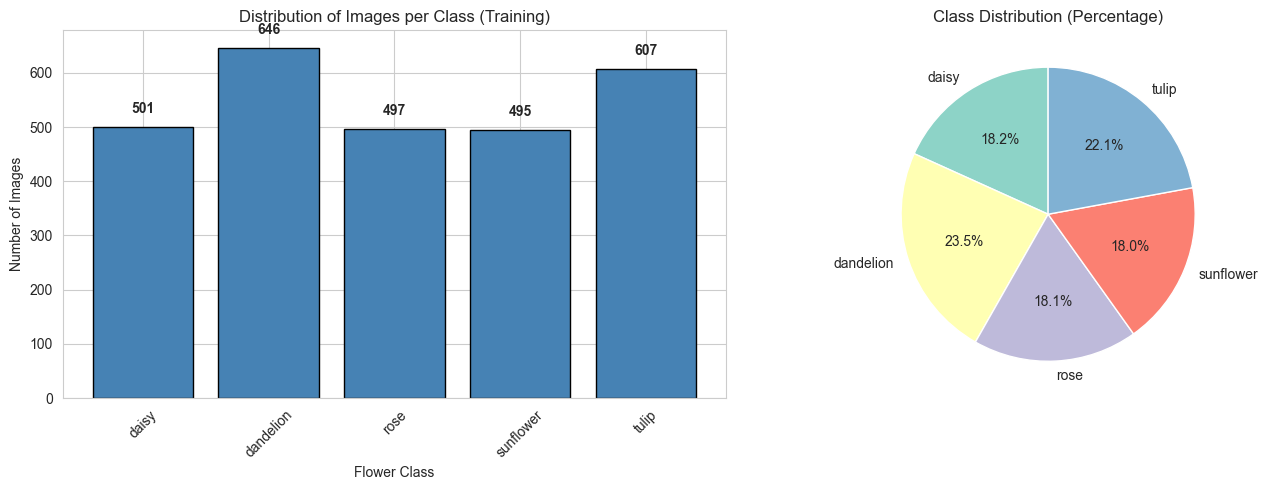

In [ ]:
# Visualisasi distribusi kelas
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Bar Chart
ax[0].bar(df_counts['Class'], df_counts['Count'], color='steelblue', edgecolor='black')
ax[0].set_xlabel('Kelas Bunga')
ax[0].set_ylabel('Jumlah Gambar')
ax[0].set_title('Distribusi Gambar per Kelas (Training)')
ax[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_counts['Count']):
    ax[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Pie Chart
colors = plt.cm.Set3(range(len(classes)))
ax[1].pie(df_counts['Count'], labels=df_counts['Class'], autopct='%1.1f%%', 
          colors=colors, startangle=90)
ax[1].set_title('Distribusi Kelas (Persentase)')

plt.tight_layout()
plt.show()


### 3.2 Visualisasi Sampel Citra
Menampilkan beberapa contoh citra dari setiap kelas untuk memahami karakteristik visual dataset.


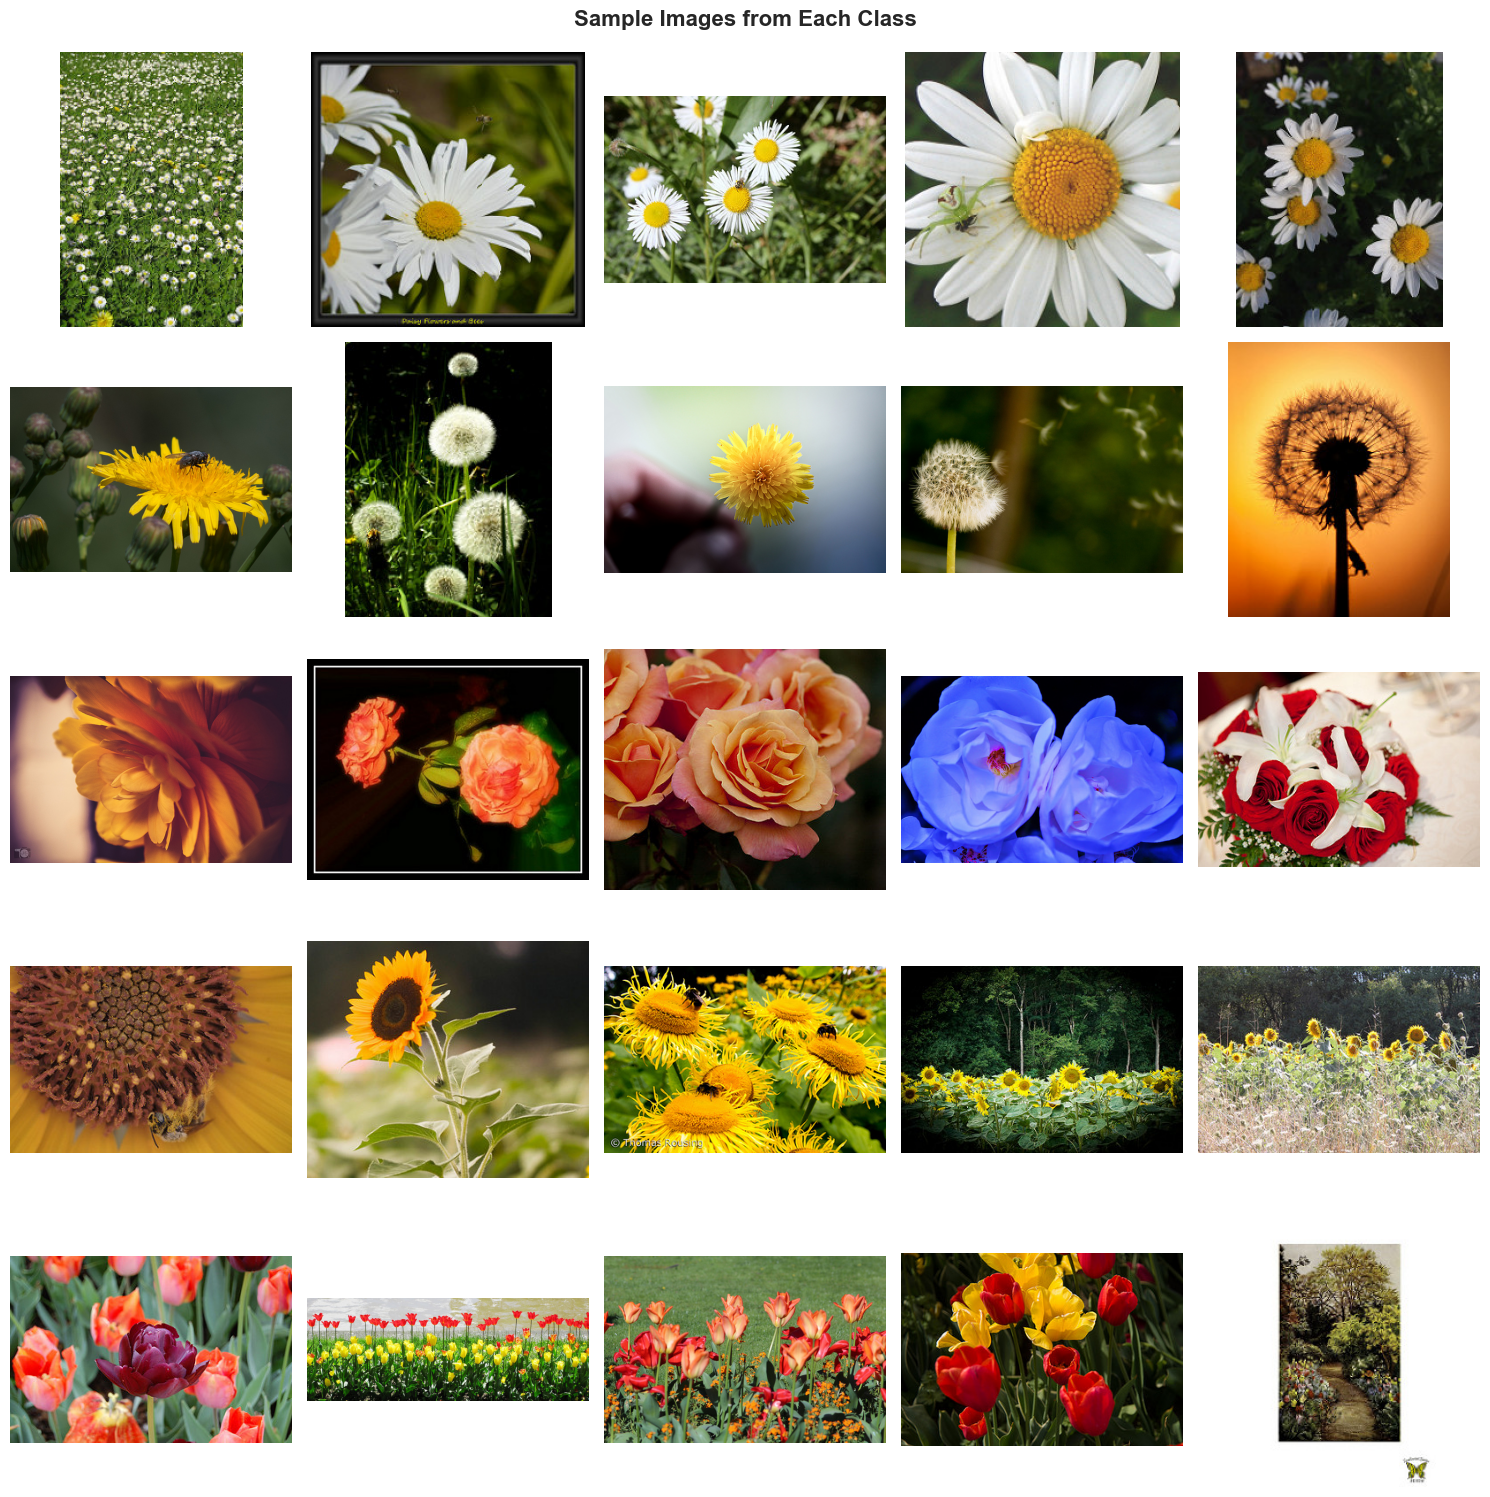

In [ ]:
n_samples = 5
fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, len(classes) * 3))

for i, class_name in enumerate(classes):
    # Ambil sampel acak dari setiap kelas
    class_images = df_train[df_train['label'] == class_name]['image_path'].sample(n=n_samples, random_state=SEED)
    
    for j, img_path in enumerate(class_images):
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        
        if j == 0:
            axes[i, j].set_ylabel(class_name.capitalize(), fontsize=12, fontweight='bold')

plt.suptitle('Sampel Citra dari Setiap Kelas', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 4. Persiapan Data (Data Preparation)
Tahap ini meliputi pemetaan label, pembagian dataset, dan pembuatan DataLoader.


### 4.1 Pemetaan Kelas dan Pembagian Data Latih-Validasi
Mengubah label teks menjadi indeks numerik dan membagi data latih menjadi set pelatihan dan validasi.


In [ ]:
# Membuat mapping dari nama kelas ke indeks dan sebaliknya
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print("Mapping Kelas ke Indeks:")
for cls, idx in class_to_idx.items():
    print(f"  {cls}: {idx}")


Class to Index mapping:
  daisy: 0
  dandelion: 1
  rose: 2
  sunflower: 3
  tulip: 4


In [ ]:
# Menambahkan kolom indeks label ke DataFrame
df_train['label_idx'] = df_train['label'].map(class_to_idx)

# Membagi dataset menjadi Train (85%) dan Validation (15%) dengan stratifikasi
train_df, val_df = train_test_split(
    df_train, test_size=0.15, stratify=df_train['label_idx'], random_state=SEED
)

print(f"Pembagian Dataset:")
print(f"  Latih (Train):    {len(train_df)} gambar ({len(train_df)/len(df_train)*100:.1f}%)")
print(f"  Validasi (Val):   {len(val_df)} gambar ({len(val_df)/len(df_train)*100:.1f}%)")
print(f"  Total:            {len(df_train)} gambar")

print(f"\nDistribusi kelas dalam split:")
split_dist = pd.DataFrame({
    'Train': train_df['label'].value_counts().sort_index(),
    'Val': val_df['label'].value_counts().sort_index()
}).fillna(0).astype(int)
print(split_dist)


Dataset Split:
  Train: 2334 images (85.0%)
  Val:   412 images (15.0%)
  Total: 2746 images

Class distribution in splits:
           Train  Val
label                
daisy        426   75
dandelion    549   97
rose         422   75
sunflower    421   74
tulip        516   91


### 4.2 Persiapan Data Uji
Menyiapkan DataFrame untuk data uji berdasarkan file CSV yang disediakan.


In [ ]:
df_test_files = pd.read_csv(test_csv_path)
df_test_files['image_path'] = df_test_files['filename'].apply(lambda x: test_dir / x)

# Verifikasi keberadaan file
existing_test_files = df_test_files[df_test_files['image_path'].apply(lambda x: x.exists())]
print(f"File uji di CSV: {len(df_test_files)}")
print(f"File uji yang ada: {len(existing_test_files)}")

if len(existing_test_files) < len(df_test_files):
    print(f"Peringatan: {len(df_test_files) - len(existing_test_files)} file uji tidak ditemukan!")

df_test_files = existing_test_files.reset_index(drop=True)
print(f"\nBeberapa file uji pertama:")
print(df_test_files.head())


Test files in CSV: 924
Existing test files: 924

First few test files:
      filename                        image_path
0  Image_1.jpg  flowers-dataset\test\Image_1.jpg
1  Image_2.jpg  flowers-dataset\test\Image_2.jpg
2  Image_3.jpg  flowers-dataset\test\Image_3.jpg
3  Image_4.jpg  flowers-dataset\test\Image_4.jpg
4  Image_5.jpg  flowers-dataset\test\Image_5.jpg


### 4.3 Kelas Dataset Kustom
Membuat kelas `Dataset` PyTorch kustom untuk memuat citra dan label.


In [ ]:
class FlowerDataset(Dataset):
    def __init__(self, dataframe, transform=None, has_labels=True):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame dengan kolom 'image_path' dan opsional 'label_idx'.
            transform (callable, optional): Transformasi yang akan diterapkan pada sampel.
            has_labels (bool): Apakah dataset memiliki label (True untuk train/val, False untuk test).
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.has_labels = has_labels
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        # Buka gambar dan konversi ke RGB
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.has_labels:
            label = int(self.dataframe.loc[idx, 'label_idx'])
            return image, torch.tensor(label, dtype=torch.long)
        else:
            return image


### 4.4 Augmentasi Data dan Transformasi
Mendefinisikan transformasi untuk data latih (dengan augmentasi) dan data validasi/uji (hanya resize dan normalisasi).


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0  # Set ke 0 untuk Windows untuk menghindari masalah multiprocessing

# Transformasi untuk Data Latih (dengan Augmentasi)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformasi untuk Data Validasi dan Uji (Tanpa Augmentasi)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Inisialisasi Dataset
train_dataset = FlowerDataset(train_df, transform=train_transforms, has_labels=True)
val_dataset = FlowerDataset(val_df, transform=val_test_transforms, has_labels=True)
test_dataset = FlowerDataset(df_test_files, transform=val_test_transforms, has_labels=False)

# Inisialisasi DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

print(f"DataLoader berhasil dibuat:")
print(f"  Batch Latih: {len(train_loader)}")
print(f"  Batch Validasi: {len(val_loader)}")
print(f"  Batch Uji: {len(test_loader)}")


DataLoaders created:
  Train batches: 73
  Val batches: 13
  Test batches: 29


### 4.5 Visualisasi Sampel Augmentasi
Melihat efek augmentasi data pada satu citra sampel.


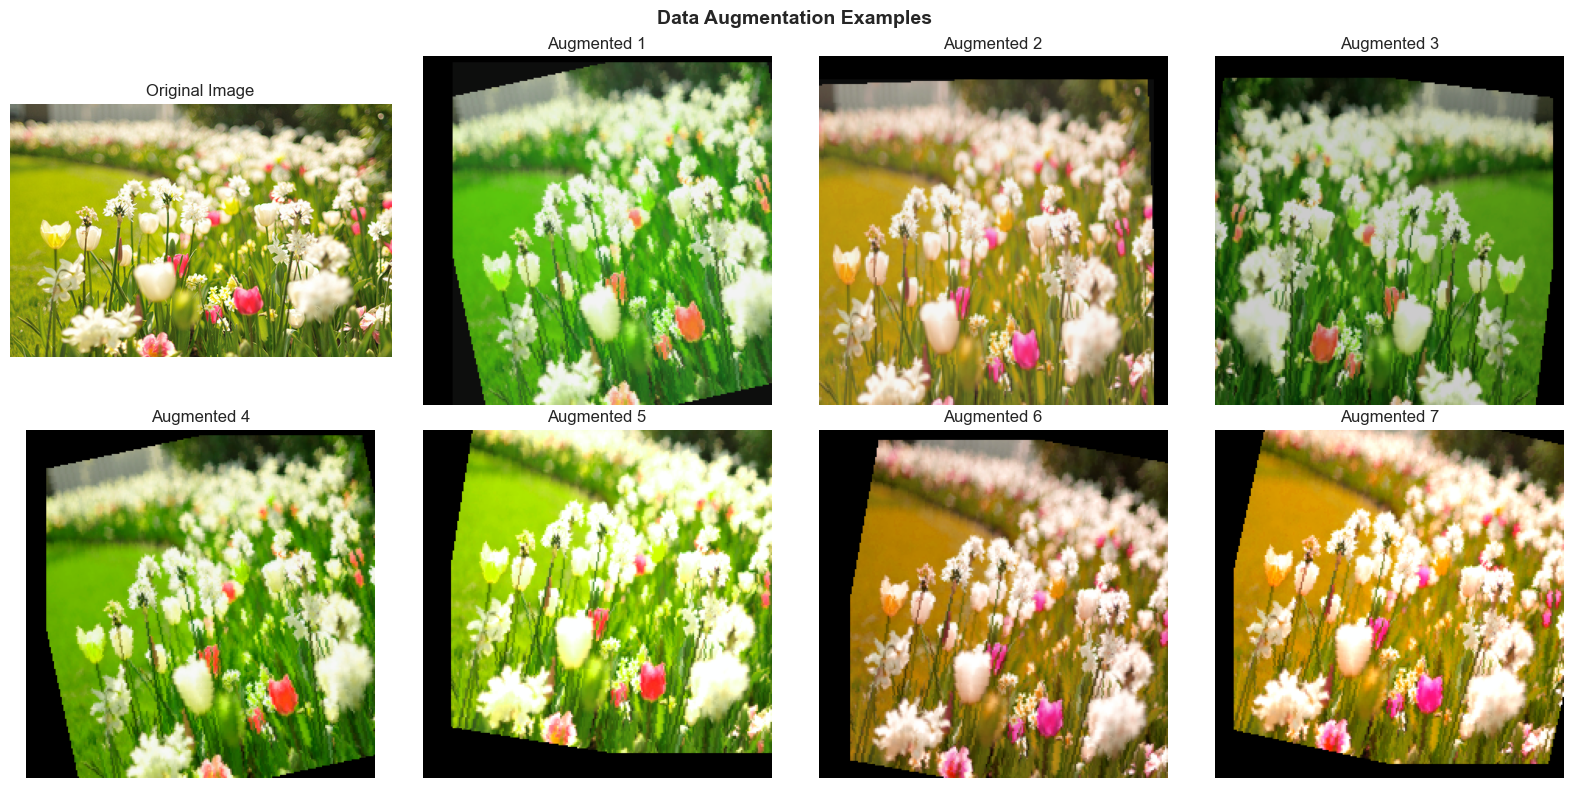

In [ ]:
sample_img_path = train_df.iloc[0]['image_path']
sample_img = Image.open(sample_img_path).convert('RGB')

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Citra Asli')
axes[0, 0].axis('off')

for i in range(1, 8):
    # Terapkan transformasi
    augmented = train_transforms(sample_img)
    # Denormalisasi untuk visualisasi
    augmented = augmented.permute(1, 2, 0).numpy()
    augmented = (augmented * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    augmented = np.clip(augmented, 0, 1)
    
    row = i // 4
    col = i % 4
    axes[row, col].imshow(augmented)
    axes[row, col].set_title(f'Augmentasi {i}')
    axes[row, col].axis('off')

plt.suptitle('Contoh Augmentasi Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Definisi Model
Mendefinisikan arsitektur untuk ketiga model Vision Transformer yang akan dibandingkan.


### 5.1 Swin Transformer
Menggunakan varian `swin_tiny_patch4_window7_224`.


In [ ]:
def create_swin_transformer(num_classes, pretrained=True):
    # Memuat model pre-trained dari timm
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
    
    # Mengganti head klasifikasi sesuai jumlah kelas dataset kita
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes)
    
    return model

swin_model = create_swin_transformer(num_classes=len(classes))
print("Swin Transformer berhasil dibuat")
print(f"Total parameter: {sum(p.numel() for p in swin_model.parameters()):,}")
print(f"Parameter yang dapat dilatih: {sum(p.numel() for p in swin_model.parameters() if p.requires_grad):,}")


Swin Transformer created successfully
Total parameters: 27,523,199
Trainable parameters: 27,523,199


### 5.2 DeiT (Data-efficient Image Transformer)
Menggunakan varian `deit_tiny_patch16_224`.


In [ ]:
def create_deit(num_classes, pretrained=True):
    # Memuat model pre-trained dari timm
    model = timm.create_model('deit_tiny_patch16_224', pretrained=pretrained)
    
    # Mengganti head klasifikasi
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, num_classes)
    
    return model

deit_model = create_deit(num_classes=len(classes))
print("DeiT berhasil dibuat")
print(f"Total parameter: {sum(p.numel() for p in deit_model.parameters()):,}")
print(f"Parameter yang dapat dilatih: {sum(p.numel() for p in deit_model.parameters() if p.requires_grad):,}")


DeiT created successfully
Total parameters: 5,525,381
Trainable parameters: 5,525,381


### 5.3 MAE (Masked Autoencoder)
Menggunakan encoder ViT-Base yang telah dilatih dengan metode MAE.


In [ ]:
def create_mae_vit(num_classes, pretrained=True):
    try:
        # Mencoba memuat model MAE
        model = timm.create_model('vit_base_patch16_224.mae', pretrained=pretrained)
        
        # Menyesuaikan head klasifikasi
        if hasattr(model, 'head'):
            if hasattr(model.head, 'in_features'):
                in_features = model.head.in_features
            elif hasattr(model, 'num_features'):
                in_features = model.num_features
            else:
                in_features = 768  # Default ViT-Base
        else:
            in_features = 768
            
        model.head = nn.Linear(in_features, num_classes)
        print("Menggunakan model MAE ViT")
        return model
        
    except Exception as e:
        print(f"Error memuat model MAE: {e}")
        print("Fallback ke ViT-Base standar dengan bobot ImageNet21k...")
        
        # Fallback ke ViT standar jika MAE gagal
        model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)
        print("Menggunakan ViT-Base standar (valid untuk perbandingan)")
        return model

mae_model = create_mae_vit(num_classes=len(classes))
print("Model berhasil dibuat")
print(f"Total parameter: {sum(p.numel() for p in mae_model.parameters()):,}")
print(f"Parameter yang dapat dilatih: {sum(p.numel() for p in mae_model.parameters() if p.requires_grad):,}")


Using MAE ViT model
Model created successfully
Total parameters: 85,802,501
Trainable parameters: 85,802,501


### 5.4 Perbandingan Parameter Model
Membandingkan ukuran dan jumlah parameter dari ketiga model.


In [ ]:
def get_model_size_mb(model):
    """Menghitung ukuran model dalam Megabytes (MB)"""
    param_size = sum([param.nelement() * param.element_size() for param in model.parameters()])
    buffer_size = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

models_info = {
    'Swin Transformer': swin_model,
    'DeiT': deit_model,
    'MAE ViT': mae_model
}

params_comparison = []
for name, model in models_info.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable = total_params - trainable_params
    size_mb = get_model_size_mb(model)
    
    params_comparison.append({
        'Model': name,
        'Total Parameter': f"{total_params:,}",
        'Parameter Terlatih': f"{trainable_params:,}",
        'Parameter Non-latih': f"{non_trainable:,}",
        'Ukuran Model (MB)': f"{size_mb:.2f}"
    })

df_params = pd.DataFrame(params_comparison)
print("\n" + "="*80)
print("PERBANDINGAN PARAMETER MODEL")
print("="*80)
print(df_params.to_string(index=False))
print("="*80)



MODEL PARAMETERS COMPARISON
           Model Total Parameters Trainable Parameters Non-trainable Parameters Model Size (MB)
Swin Transformer       27,523,199           27,523,199                        0          106.06
            DeiT        5,525,381            5,525,381                        0           21.08
         MAE ViT       85,802,501           85,802,501                        0          327.31


## 6. Konfigurasi Pelatihan
Menentukan hyperparameter dan fungsi loss yang akan digunakan.


In [ ]:
EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

criterion = nn.CrossEntropyLoss()

print(f"Konfigurasi Pelatihan:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Ukuran Citra: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Optimizer: AdamW")
print(f"  Fungsi Loss: CrossEntropyLoss")


Training Configuration:
  Epochs: 10
  Learning Rate: 0.0001
  Weight Decay: 0.0001
  Batch Size: 32
  Image Size: 224x224
  Optimizer: AdamW
  Loss Function: CrossEntropyLoss


### 6.1 Fungsi Pelatihan dan Evaluasi
Mendefinisikan fungsi `train_epoch` dan `validate_epoch` untuk proses training loop.


In [ ]:
def prepare_logits(model_output):
    """Memastikan output model berupa logits rank-2 untuk klasifikasi"""
    if isinstance(model_output, (tuple, list)):
        model_output = model_output[0]
    if isinstance(model_output, dict):
        if 'logits' in model_output:
            model_output = model_output['logits']
        else:
            model_output = next(iter(model_output.values()))
    if hasattr(model_output, 'logits'):
        model_output = model_output.logits
    if torch.is_tensor(model_output) and model_output.dim() > 2:
        model_output = model_output.reshape(model_output.size(0), model_output.size(1), -1)
        model_output = model_output.mean(dim=-1)
    return model_output

def train_epoch(model, loader, criterion, optimizer, device):
    """Melatih model untuk satu epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Pelatihan', leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = prepare_logits(model(inputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    """Mengevaluasi model pada set validasi"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validasi', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = prepare_logits(model(inputs))
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs, device):
    """Fungsi utama untuk menjalankan pelatihan model"""
    print(f"\n{'='*60}")
    print(f"Melatih {model_name}")
    print(f"{'='*60}")

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    best_model_wts = None

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        if scheduler is not None:
            scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            print(f"✓ Model terbaik baru! Val Acc: {best_val_acc*100:.2f}%")

    total_time = time.time() - start_time
    print(f"\nPelatihan selesai dalam {total_time//60:.0f}m {total_time%60:.0f}s")
    print(f"Val Acc Terbaik: {best_val_acc*100:.2f}%")

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, history


## 7. Pelatihan Model (Training)
Melatih ketiga model secara berurutan dan menyimpan riwayat pelatihannya.


### 7.1 Melatih Swin Transformer


In [ ]:
# Mengurangi batch size jika diperlukan (misal untuk GPU dengan VRAM terbatas)
BATCH_SIZE = 16  # Dikurangi dari 32

# Membuat ulang DataLoader dengan batch size baru
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=False)

print(f"DataLoader dibuat ulang dengan BATCH_SIZE={BATCH_SIZE}")


DataLoaders recreated with BATCH_SIZE=16


In [ ]:
swin_model = swin_model.to(device)
optimizer_swin = optim.AdamW(swin_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_swin = optim.lr_scheduler.CosineAnnealingLR(optimizer_swin, T_max=EPOCHS)

swin_model, swin_history = train_model(
    swin_model, 'Swin Transformer', train_loader, val_loader, 
    criterion, optimizer_swin, scheduler_swin, EPOCHS, device
)



Training Swin Transformer

Epoch 1/10
------------------------------


Training:   0%|          | 0/146 [00:00<?, ?it/s]

Train Loss: 0.9386 | Train Acc: 65.81%
Val Loss: 0.3299 | Val Acc: 89.81%
✓ New best model! Val Acc: 89.81%

Epoch 2/10
------------------------------


Train Loss: 0.3712 | Train Acc: 87.36%
Val Loss: 0.1983 | Val Acc: 92.48%
✓ New best model! Val Acc: 92.48%

Epoch 3/10
------------------------------


Train Loss: 0.2219 | Train Acc: 93.02%
Val Loss: 0.2490 | Val Acc: 91.26%

Epoch 4/10
------------------------------


Train Loss: 0.1594 | Train Acc: 95.07%
Val Loss: 0.1643 | Val Acc: 95.63%
✓ New best model! Val Acc: 95.63%

Epoch 5/10
------------------------------


Train Loss: 0.1019 | Train Acc: 96.23%
Val Loss: 0.1406 | Val Acc: 96.36%
✓ New best model! Val Acc: 96.36%

Epoch 6/10
------------------------------


Train Loss: 0.0668 | Train Acc: 98.07%
Val Loss: 0.1489 | Val Acc: 96.12%

Epoch 7/10
------------------------------


Train Loss: 0.0484 | Train Acc: 98.50%
Val Loss: 0.1367 | Val Acc: 96.12%

Epoch 8/10
------------------------------


Train Loss: 0.0289 | Train Acc: 99.31%
Val Loss: 0.1204 | Val Acc: 96.84%
✓ New best model! Val Acc: 96.84%

Epoch 9/10
------------------------------


Train Loss: 0.0245 | Train Acc: 99.27%
Val Loss: 0.1102 | Val Acc: 97.33%
✓ New best model! Val Acc: 97.33%

Epoch 10/10
------------------------------


Train Loss: 0.0216 | Train Acc: 99.27%
Val Loss: 0.1102 | Val Acc: 96.60%

Training completed in 12m 33s
Best Val Acc: 97.33%


### 7.2 Melatih DeiT


In [ ]:
deit_model = deit_model.to(device)
optimizer_deit = optim.AdamW(deit_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_deit = optim.lr_scheduler.CosineAnnealingLR(optimizer_deit, T_max=EPOCHS)

deit_model, deit_history = train_model(
    deit_model, 'DeiT', train_loader, val_loader, 
    criterion, optimizer_deit, scheduler_deit, EPOCHS, device
)



Training DeiT

Epoch 1/10
------------------------------


Train Loss: 0.4934 | Train Acc: 82.26%
Val Loss: 0.2720 | Val Acc: 89.81%
✓ New best model! Val Acc: 89.81%

Epoch 2/10
------------------------------


Train Loss: 0.2068 | Train Acc: 92.33%
Val Loss: 0.1880 | Val Acc: 94.17%
✓ New best model! Val Acc: 94.17%

Epoch 3/10
------------------------------


Train Loss: 0.1284 | Train Acc: 95.63%
Val Loss: 0.2123 | Val Acc: 93.69%

Epoch 4/10
------------------------------


Train Loss: 0.0807 | Train Acc: 97.30%
Val Loss: 0.1837 | Val Acc: 93.69%

Epoch 5/10
------------------------------


Train Loss: 0.0767 | Train Acc: 97.26%
Val Loss: 0.1708 | Val Acc: 95.15%
✓ New best model! Val Acc: 95.15%

Epoch 6/10
------------------------------


Train Loss: 0.0333 | Train Acc: 99.19%
Val Loss: 0.1689 | Val Acc: 94.66%

Epoch 7/10
------------------------------


Train Loss: 0.0275 | Train Acc: 99.14%
Val Loss: 0.1484 | Val Acc: 95.39%
✓ New best model! Val Acc: 95.39%

Epoch 8/10
------------------------------


Train Loss: 0.0136 | Train Acc: 99.66%
Val Loss: 0.1484 | Val Acc: 95.63%
✓ New best model! Val Acc: 95.63%

Epoch 9/10
------------------------------


Train Loss: 0.0084 | Train Acc: 99.83%
Val Loss: 0.1427 | Val Acc: 96.36%
✓ New best model! Val Acc: 96.36%

Epoch 10/10
------------------------------


Train Loss: 0.0080 | Train Acc: 99.87%
Val Loss: 0.1413 | Val Acc: 96.12%

Training completed in 6m 57s
Best Val Acc: 96.36%


### 7.3 Melatih MAE ViT


In [ ]:
mae_model = mae_model.to(device)
optimizer_mae = optim.AdamW(mae_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_mae = optim.lr_scheduler.CosineAnnealingLR(optimizer_mae, T_max=EPOCHS)

mae_model, mae_history = train_model(
    mae_model, 'MAE ViT', train_loader, val_loader, 
    criterion, optimizer_mae, scheduler_mae, EPOCHS, device
)



Training MAE ViT

Epoch 1/10
------------------------------


Train Loss: 0.6495 | Train Acc: 75.28%
Val Loss: 0.2515 | Val Acc: 91.75%
✓ New best model! Val Acc: 91.75%

Epoch 2/10
------------------------------


Train Loss: 0.3321 | Train Acc: 87.92%
Val Loss: 0.2721 | Val Acc: 90.78%

Epoch 3/10
------------------------------


Train Loss: 0.2660 | Train Acc: 89.85%
Val Loss: 0.2201 | Val Acc: 91.99%
✓ New best model! Val Acc: 91.99%

Epoch 4/10
------------------------------


Train Loss: 0.1641 | Train Acc: 93.96%
Val Loss: 0.2149 | Val Acc: 93.20%
✓ New best model! Val Acc: 93.20%

Epoch 5/10
------------------------------


Train Loss: 0.1248 | Train Acc: 95.67%
Val Loss: 0.1800 | Val Acc: 94.17%
✓ New best model! Val Acc: 94.17%

Epoch 6/10
------------------------------


Train Loss: 0.0814 | Train Acc: 97.43%
Val Loss: 0.2212 | Val Acc: 92.23%

Epoch 7/10
------------------------------


Train Loss: 0.0483 | Train Acc: 98.59%
Val Loss: 0.1955 | Val Acc: 94.17%

Epoch 8/10
------------------------------


Train Loss: 0.0253 | Train Acc: 99.19%
Val Loss: 0.1701 | Val Acc: 95.39%
✓ New best model! Val Acc: 95.39%

Epoch 9/10
------------------------------


Train Loss: 0.0124 | Train Acc: 99.74%
Val Loss: 0.1796 | Val Acc: 94.90%

Epoch 10/10
------------------------------


Train Loss: 0.0129 | Train Acc: 99.66%
Val Loss: 0.1683 | Val Acc: 95.39%

Training completed in 44m 28s
Best Val Acc: 95.39%


### 7.4 Visualisasi Riwayat Pelatihan
Memplot kurva Loss dan Akurasi untuk setiap model.


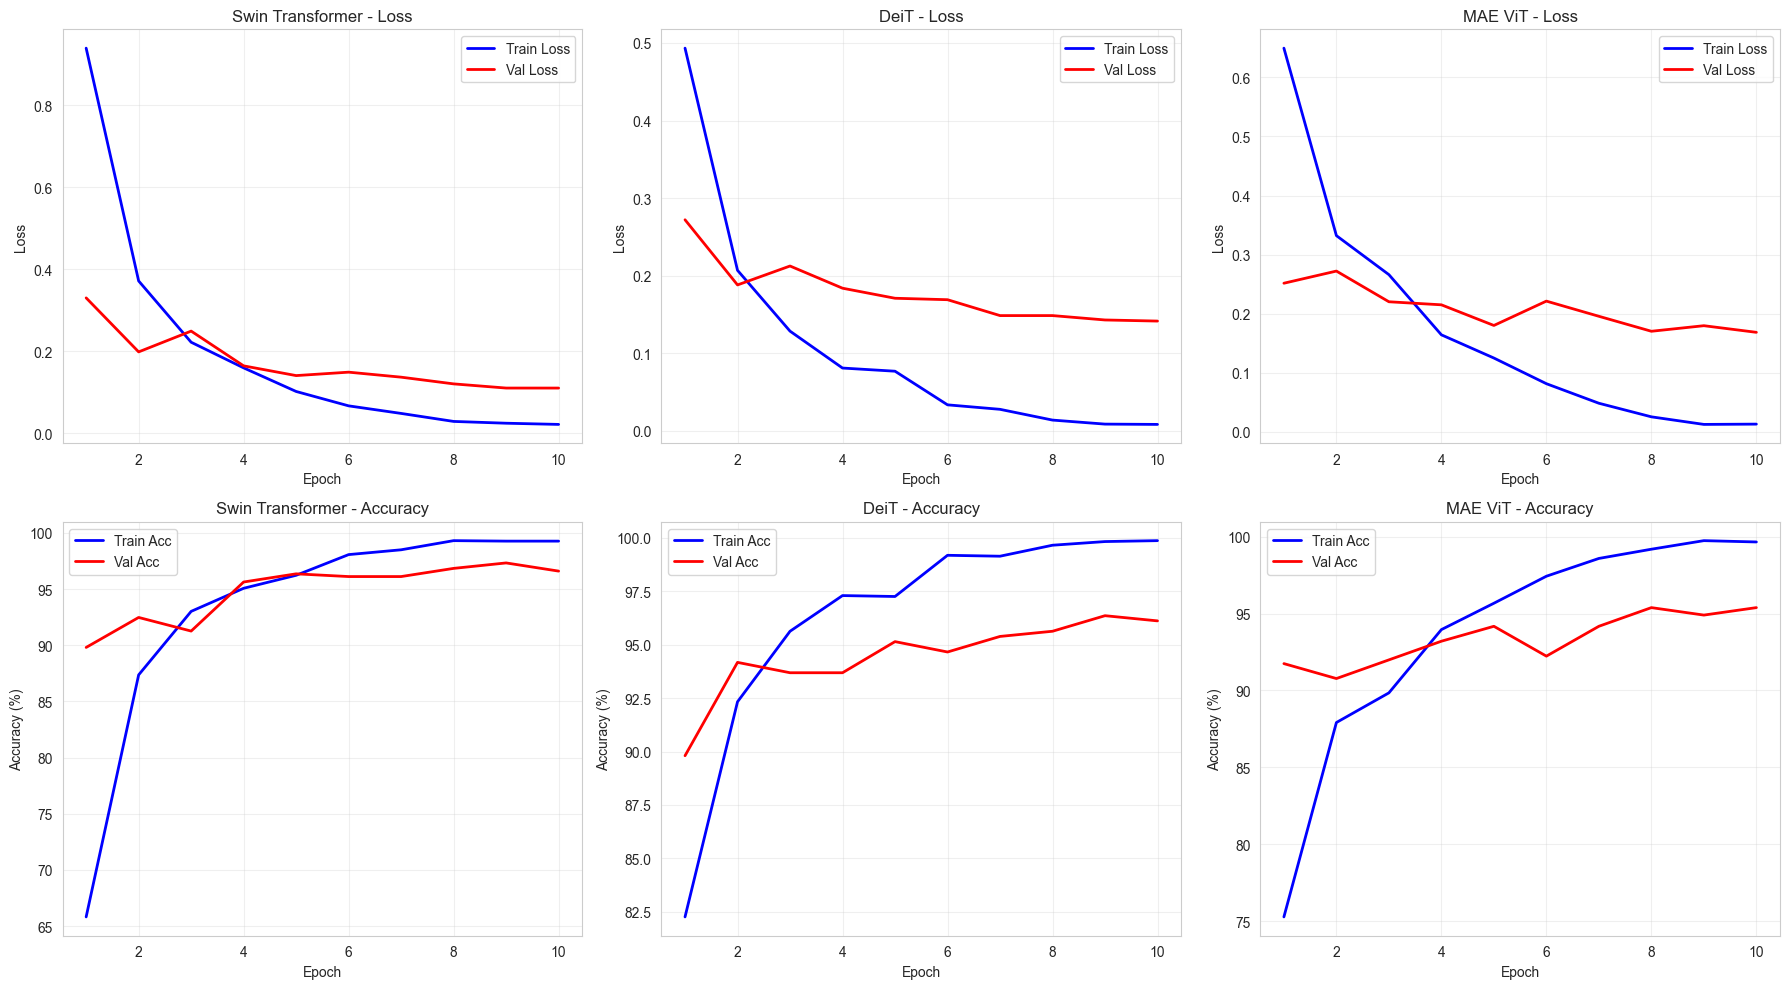

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = {
    'Swin Transformer': swin_history,
    'DeiT': deit_history,
    'MAE ViT': mae_history
}

for idx, (name, history) in enumerate(histories.items()):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    axes[0, idx].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, idx].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].set_title(f'{name} - Loss')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Plot Akurasi
    axes[1, idx].plot(epochs_range, [acc*100 for acc in history['train_acc']], 'b-', label='Train Acc', linewidth=2)
    axes[1, idx].plot(epochs_range, [acc*100 for acc in history['val_acc']], 'r-', label='Val Acc', linewidth=2)
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Akurasi (%)')
    axes[1, idx].set_title(f'{name} - Akurasi')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 7.5 Kurva Perbandingan Pelatihan
Membandingkan kinerja validasi ketiga model dalam satu grafik.


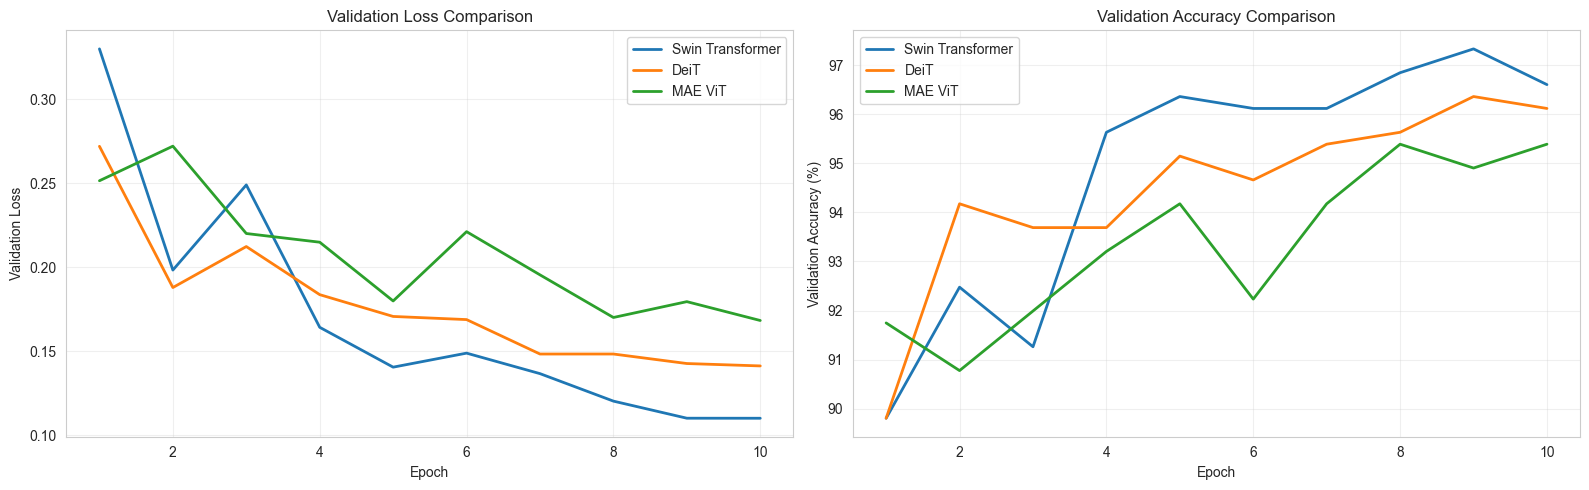

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for name, history in histories.items():
    epochs_range = range(1, len(history['train_loss']) + 1)
    axes[0].plot(epochs_range, history['val_loss'], label=name, linewidth=2)
    axes[1].plot(epochs_range, [acc*100 for acc in history['val_acc']], label=name, linewidth=2)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Perbandingan Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Perbandingan Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Evaluasi Data Validasi
Melakukan evaluasi mendalam menggunakan metrik Akurasi, Presisi, Recall, dan F1-Score.


In [ ]:
def evaluate_model(model, data_loader, device, class_names):
    """Mengevaluasi model dan menghitung berbagai metrik performa"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Mengevaluasi'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = prepare_logits(model(inputs))
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Hitung metrik
    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    results = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    return results


In [ ]:
print("Mengevaluasi model pada set validasi...\n")

swin_results = evaluate_model(swin_model, val_loader, device, classes)
print(f"✓ Swin Transformer - Val Accuracy: {swin_results['accuracy']*100:.2f}%")

deit_results = evaluate_model(deit_model, val_loader, device, classes)
print(f"✓ DeiT - Val Accuracy: {deit_results['accuracy']*100:.2f}%")

mae_results = evaluate_model(mae_model, val_loader, device, classes)
print(f"✓ MAE ViT - Val Accuracy: {mae_results['accuracy']*100:.2f}%")


Evaluating models on validation set...



Evaluating: 100%|██████████| 26/26 [00:04<00:00,  5.53it/s]


✓ Swin Transformer - Val Accuracy: 96.60%


Evaluating: 100%|██████████| 26/26 [00:07<00:00,  3.68it/s]


✓ DeiT - Val Accuracy: 96.12%


Evaluating: 100%|██████████| 26/26 [00:30<00:00,  1.19s/it]

✓ MAE ViT - Val Accuracy: 95.39%


### 8.1 Tabel Perbandingan Metrik Performa


In [ ]:
results_dict = {
    'Swin Transformer': swin_results,
    'DeiT': deit_results,
    'MAE ViT': mae_results
}

metrics_comparison = []
for name, results in results_dict.items():
    metrics_comparison.append({
        'Model': name,
        'Akurasi': f"{results['accuracy']*100:.2f}%",
        'Precision (Macro)': f"{results['precision_macro']*100:.2f}%",
        'Recall (Macro)': f"{results['recall_macro']*100:.2f}%",
        'F1-Score (Macro)': f"{results['f1_macro']*100:.2f}%"
    })

df_metrics = pd.DataFrame(metrics_comparison)
print("\n" + "="*90)
print("PERBANDINGAN METRIK PERFORMA (SET VALIDASI)")
print("="*90)
print(df_metrics.to_string(index=False))
print("="*90)



PERFORMANCE METRICS COMPARISON (VALIDATION SET)
           Model Accuracy Precision (Macro) Recall (Macro) F1-Score (Macro)
Swin Transformer   96.60%            96.62%         96.59%           96.60%
            DeiT   96.12%            96.11%         96.18%           96.14%
         MAE ViT   95.39%            95.50%         95.25%           95.34%


### 8.2 Metrik Per Kelas
Melihat performa model untuk setiap jenis bunga.


In [ ]:
for model_name, results in results_dict.items():
    print(f"\n{'='*70}")
    print(f"{model_name} - Metrik Per Kelas")
    print(f"{'='*70}")
    
    per_class_df = pd.DataFrame({
        'Kelas': classes,
        'Precision': [f"{p*100:.2f}%" for p in results['precision_per_class']],
        'Recall': [f"{r*100:.2f}%" for r in results['recall_per_class']],
        'F1-Score': [f"{f*100:.2f}%" for f in results['f1_per_class']]
    })
    print(per_class_df.to_string(index=False))
    print()



Swin Transformer - Per-Class Metrics
    Class Precision  Recall F1-Score
    daisy    98.67%  98.67%   98.67%
dandelion    97.00% 100.00%   98.48%
     rose    93.33%  93.33%   93.33%
sunflower    98.65%  98.65%   98.65%
    tulip    95.45%  92.31%   93.85%


DeiT - Per-Class Metrics
    Class Precision  Recall F1-Score
    daisy    98.67%  98.67%   98.67%
dandelion    97.94%  97.94%   97.94%
     rose    93.24%  92.00%   92.62%
sunflower    97.37% 100.00%   98.67%
    tulip    93.33%  92.31%   92.82%


MAE ViT - Per-Class Metrics
    Class Precision  Recall F1-Score
    daisy    98.61%  94.67%   96.60%
dandelion    94.17% 100.00%   97.00%
     rose    93.24%  92.00%   92.62%
sunflower    96.00%  97.30%   96.64%
    tulip    95.45%  92.31%   93.85%



### 8.3 Matriks Kebingungan (Confusion Matrix)
Visualisasi kesalahan prediksi model.


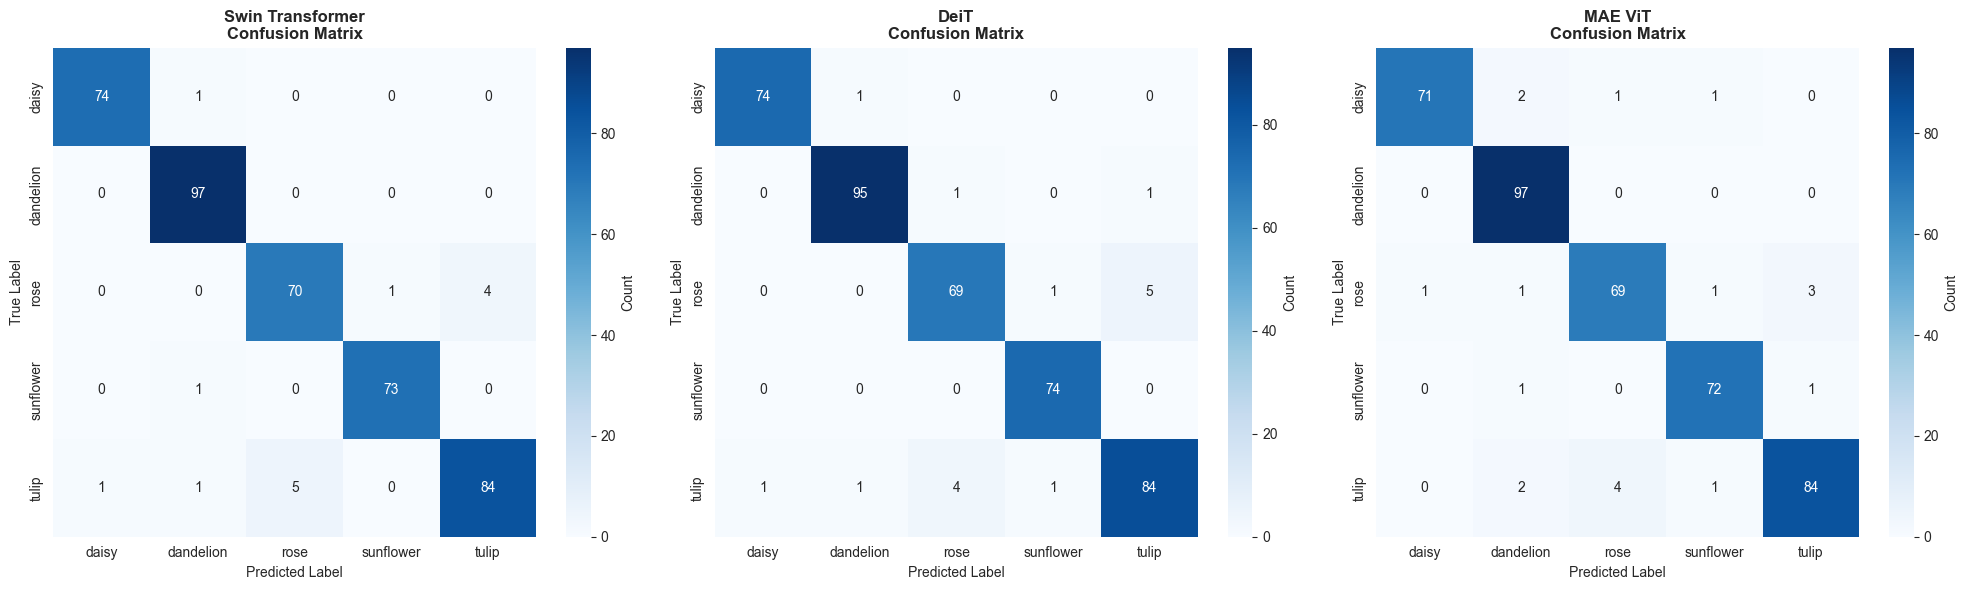

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (name, results) in enumerate(results_dict.items()):
    cm = results['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, 
                yticklabels=classes, ax=axes[idx], cbar_kws={'label': 'Jumlah'})
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('Label Asli')
    axes[idx].set_xlabel('Label Prediksi')

plt.tight_layout()
plt.show()


## 9. Analisis Waktu Inferensi
Mengukur kecepatan model dalam memproses citra (throughput dan latensi).


In [ ]:
def measure_inference_time(model, data_loader, device, num_warmup=10, num_iterations=100):
    """Mengukur waktu inferensi rata-rata per batch dan per citra"""
    model.eval()

    sample_batch = next(iter(data_loader))

    def _extract_inputs(batch):
        if torch.is_tensor(batch):
            return batch
        if isinstance(batch, dict):
            if 'pixel_values' in batch:
                return batch['pixel_values']
            return next(iter(batch.values()))
        if isinstance(batch, (tuple, list)):
            inputs = batch[0]
            if isinstance(inputs, list) and len(inputs) > 0 and torch.is_tensor(inputs[0]):
                inputs = torch.stack(inputs)
            return _extract_inputs(inputs)
        raise TypeError('Tipe batch tidak didukung untuk pengukuran inferensi')

    sample_batch = _extract_inputs(sample_batch).to(device)

    # Warmup (pemanasan)
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(sample_batch)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    times = []
    with torch.no_grad():
        for _ in tqdm(range(num_iterations), desc='Mengukur waktu inferensi'):
            start = time.time()
            _ = model(sample_batch)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            times.append((end - start) * 1000) # konversi ke ms

    avg_time_per_batch = np.mean(times)
    std_time_per_batch = np.std(times)
    avg_time_per_image = avg_time_per_batch / sample_batch.size(0)
    throughput = 1000 / avg_time_per_image

    return {
        'avg_time_per_batch_ms': avg_time_per_batch,
        'std_time_per_batch_ms': std_time_per_batch,
        'avg_time_per_image_ms': avg_time_per_image,
        'throughput_images_per_sec': throughput
    }


In [ ]:
print("Mengukur waktu inferensi...\n")

swin_inference = measure_inference_time(swin_model, val_loader, device)
print(f"✓ Swin Transformer inferensi selesai")

deit_inference = measure_inference_time(deit_model, val_loader, device)
print(f"✓ DeiT inferensi selesai")

mae_inference = measure_inference_time(mae_model, val_loader, device)
print(f"✓ MAE ViT inferensi selesai")


Measuring inference times...



Measuring inference time: 100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


✓ Swin Transformer inference measured


Measuring inference time: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


✓ DeiT inference measured


Measuring inference time: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it]

✓ MAE ViT inference measured


In [ ]:
inference_dict = {
    'Swin Transformer': swin_inference,
    'DeiT': deit_inference,
    'MAE ViT': mae_inference
}

inference_comparison = []
for name, inf_data in inference_dict.items():
    inference_comparison.append({
        'Model': name,
        'Rata-rata Waktu per Citra (ms)': f"{inf_data['avg_time_per_image_ms']:.2f}",
        'Std Dev Waktu per Batch (ms)': f"{inf_data['std_time_per_batch_ms']:.2f}",
        'Throughput (citra/detik)': f"{inf_data['throughput_images_per_sec']:.2f}"
    })

df_inference = pd.DataFrame(inference_comparison)
print("\n" + "="*90)
print("PERBANDINGAN WAKTU INFERENSI")
print("="*90)
print(df_inference.to_string(index=False))
print("="*90)
print(f"\nPerangkat Keras: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")



INFERENCE TIME COMPARISON
           Model Avg Time per Image (ms) Std Time per Batch (ms) Throughput (images/sec)
Swin Transformer                    6.38                    0.65                  156.86
            DeiT                   12.61                    4.22                   79.32
         MAE ViT                   73.03                   31.70                   13.69

Hardware: cuda
GPU: NVIDIA GeForce RTX 2050


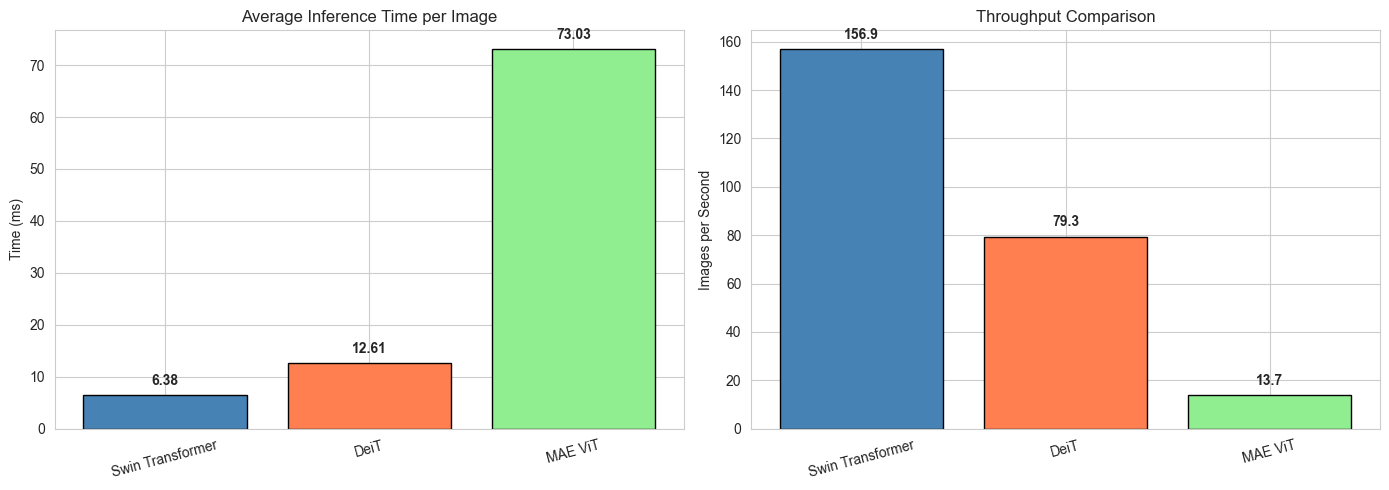

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(inference_dict.keys())
avg_times = [inf_data['avg_time_per_image_ms'] for inf_data in inference_dict.values()]
throughputs = [inf_data['throughput_images_per_sec'] for inf_data in inference_dict.values()]

# Plot Waktu Inferensi
axes[0].bar(model_names, avg_times, color=['steelblue', 'coral', 'lightgreen'], edgecolor='black')
axes[0].set_ylabel('Waktu (ms)')
axes[0].set_title('Rata-rata Waktu Inferensi per Citra')
axes[0].tick_params(axis='x', rotation=15)
for i, v in enumerate(avg_times):
    axes[0].text(i, v + max(avg_times)*0.02, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot Throughput
axes[1].bar(model_names, throughputs, color=['steelblue', 'coral', 'lightgreen'], edgecolor='black')
axes[1].set_ylabel('Citra per Detik')
axes[1].set_title('Perbandingan Throughput')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(throughputs):
    axes[1].text(i, v + max(throughputs)*0.02, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 10. Prediksi Data Uji
Menghasilkan prediksi untuk dataset uji (tanpa label) untuk keperluan submission.


In [ ]:
def predict_test_set(model, test_loader, device):
    """Menghasilkan prediksi untuk dataset uji"""
    model.eval()
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc='Memprediksi data uji'):
            inputs = inputs.to(device)
            outputs = prepare_logits(model(inputs))
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_preds, all_probs


In [ ]:
print("Menghasilkan prediksi untuk data uji...\n")

swin_preds, swin_probs = predict_test_set(swin_model, test_loader, device)
print(f"✓ Prediksi Swin Transformer selesai")

deit_preds, deit_probs = predict_test_set(deit_model, test_loader, device)
print(f"✓ Prediksi DeiT selesai")

mae_preds, mae_probs = predict_test_set(mae_model, test_loader, device)
print(f"✓ Prediksi MAE ViT selesai")


Generating predictions for test set...



Predicting test set: 100%|██████████| 58/58 [00:16<00:00,  3.60it/s]


✓ Swin Transformer predictions complete


Predicting test set: 100%|██████████| 58/58 [00:14<00:00,  4.10it/s]


✓ DeiT predictions complete


Predicting test set: 100%|██████████| 58/58 [01:14<00:00,  1.28s/it]

✓ MAE ViT predictions complete


### 10.1 Membuat File Submission
Menyimpan hasil prediksi ke dalam format CSV.


In [ ]:
def create_submission(predictions, filename, df_test_files, idx_to_class):
    pred_labels = [idx_to_class[pred] for pred in predictions]
    
    submission_df = pd.DataFrame({
        'prediction': pred_labels
    })
    
    submission_df.to_csv(filename, index=False)
    print(f"Submission disimpan ke: {filename}")
    print(f"Total prediksi: {len(submission_df)}")
    print(f"\nDistribusi prediksi:")
    print(submission_df['prediction'].value_counts())
    return submission_df

results_dir = Path('./results')
results_dir.mkdir(exist_ok=True)

print("Membuat file submission...\n")

print("=" * 60)
print("Swin Transformer Submission")
print("=" * 60)
swin_submission = create_submission(swin_preds, results_dir / 'swin_submission.csv', 
                                   df_test_files, idx_to_class)

print("\n" + "=" * 60)
print("DeiT Submission")
print("=" * 60)
deit_submission = create_submission(deit_preds, results_dir / 'deit_submission.csv', 
                                   df_test_files, idx_to_class)

print("\n" + "=" * 60)
print("MAE ViT Submission")
print("=" * 60)
mae_submission = create_submission(mae_preds, results_dir / 'mae_submission.csv', 
                                  df_test_files, idx_to_class)


Creating submission files...

Swin Transformer Submission
Submission saved to: results\swin_submission.csv
Total predictions: 924

Prediction distribution:
prediction
dandelion    249
sunflower    209
tulip        205
rose         135
daisy        126
Name: count, dtype: int64

DeiT Submission
Submission saved to: results\deit_submission.csv
Total predictions: 924

Prediction distribution:
prediction
dandelion    243
sunflower    213
tulip        206
rose         135
daisy        127
Name: count, dtype: int64

MAE ViT Submission
Submission saved to: results\mae_submission.csv
Total predictions: 924

Prediction distribution:
prediction
dandelion    252
sunflower    207
tulip        204
rose         136
daisy        125
Name: count, dtype: int64


## 11. Perbandingan Komprehensif
Merangkum semua metrik (parameter, akurasi, kecepatan) dalam satu tabel.


In [ ]:
comprehensive_comparison = []

for model_name in ['Swin Transformer', 'DeiT', 'MAE ViT']:
    model_obj = models_info[model_name]
    results = results_dict[model_name]
    inference = inference_dict[model_name]
    
    total_params = sum(p.numel() for p in model_obj.parameters())
    size_mb = get_model_size_mb(model_obj)
    
    comprehensive_comparison.append({
        'Model': model_name,
        'Parameter (Juta)': f"{total_params/1e6:.2f}",
        'Ukuran (MB)': f"{size_mb:.2f}",
        'Akurasi (%)': f"{results['accuracy']*100:.2f}",
        'F1-Score (%)': f"{results['f1_macro']*100:.2f}",
        'Waktu Inferensi (ms)': f"{inference['avg_time_per_image_ms']:.2f}",
        'Throughput (img/s)': f"{inference['throughput_images_per_sec']:.1f}"
    })

df_comprehensive = pd.DataFrame(comprehensive_comparison)
print("\n" + "="*100)
print("PERBANDINGAN MODEL KOMPREHENSIF")
print("="*100)
print(df_comprehensive.to_string(index=False))
print("="*100)



COMPREHENSIVE MODEL COMPARISON
           Model Parameters (M) Size (MB) Accuracy (%) F1-Score (%) Inference Time (ms) Throughput (img/s)
Swin Transformer          27.52    106.06        96.60        96.60                6.38              156.9
            DeiT           5.53     21.08        96.12        96.14               12.61               79.3
         MAE ViT          85.80    327.31        95.39        95.34               73.03               13.7


## 12. Simpan Hasil
Menyimpan semua metrik, bobot model, dan riwayat pelatihan ke disk.


In [ ]:
df_comprehensive.to_csv(results_dir / 'comprehensive_comparison.csv', index=False)
df_metrics.to_csv(results_dir / 'performance_metrics.csv', index=False)
df_inference.to_csv(results_dir / 'inference_times.csv', index=False)
df_params.to_csv(results_dir / 'model_parameters.csv', index=False)

# Simpan bobot model
torch.save(swin_model.state_dict(), results_dir / 'swin_transformer.pth')
torch.save(deit_model.state_dict(), results_dir / 'deit.pth')
torch.save(mae_model.state_dict(), results_dir / 'mae_vit.pth')

# Simpan riwayat pelatihan
import json
histories_dict = {
    'swin': swin_history,
    'deit': deit_history,
    'mae': mae_history
}
with open(results_dir / 'training_histories.json', 'w') as f:
    json.dump(histories_dict, f, indent=2)

print("✓ Semua hasil disimpan ke direktori ./results/")
print(f"\nFile yang disimpan:")
print(f"  - comprehensive_comparison.csv")
print(f"  - performance_metrics.csv")
print(f"  - inference_times.csv")
print(f"  - model_parameters.csv")
print(f"  - Bobot Model (swin_transformer.pth, deit.pth, mae_vit.pth)")
print(f"  - training_histories.json")
print(f"  - File Submission:")
print(f"    • swin_submission.csv")
print(f"    • deit_submission.csv")
print(f"    • mae_submission.csv")


✓ All results saved to ./results/ directory

Saved files:
  - comprehensive_comparison.csv
  - performance_metrics.csv
  - inference_times.csv
  - model_parameters.csv
  - Model weights (swin_transformer.pth, deit.pth, mae_vit.pth)
  - training_histories.json
  - Submission files:
    • swin_submission.csv
    • deit_submission.csv
    • mae_submission.csv
    • ensemble_submission.csv
